Clean data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('../data.csv')

In [8]:
df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


In [9]:
df.isnull().sum()
df.fillna(method='ffill', inplace=True)

C:\Users\tosca\AppData\Local\Temp\ipykernel_15040\2903114193.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Encoder

In [10]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

In [11]:
le_sex = LabelEncoder()
df['sex'] = le_sex.fit_transform(df['sex'])

ordinal_encoder = OrdinalEncoder(categories=[['Incomplete secondary education', 'Secondary education', 'Secondary special education','Incomplete higher education', 'Higher education', 'PhD degree']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

target_encoder = TargetEncoder(cols=['product_type', 'family_status'], smoothing=1.0)
df[['product_type', 'family_status']] = target_encoder.fit_transform(df[['product_type', 'family_status']], df['bad_client_target'])

df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,1,2.0,0.226908,0,2,21000,0.104080,0,0,0
1,1,19000,6,20,1,2.0,0.076433,1,2,17000,0.104080,3,1,0
2,1,29000,12,23,0,2.0,0.076433,0,2,31000,0.104080,2,0,0
3,1,10000,12,30,1,2.0,0.226908,1,2,31000,0.115385,3,1,0
4,1,14500,12,25,0,4.0,0.226908,0,2,26000,0.139640,0,1,0


Verification de colinéarité

In [12]:
import numpy as np

correlation_matrix = df.corr()
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if (correlation_matrix.iloc[i, j] == 1 or correlation_matrix.iloc[i, j] == -1) and i != j :
                print(f"Correlation of 1 or -1 found between '{correlation_matrix.index[i]}' and '{correlation_matrix.columns[j]}'")

Data set

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [14]:
X = df.drop(columns=['bad_client_target']) # Region and phone op are useless data but better benchmark with 
y = df['bad_client_target'] 

In [15]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #divide dataset 80/20

Standardisation

In [16]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)  # Normalisation des données, (x-µ)/σ où : x = data, µ = moyenne de la colonne, σ = ecart-type de la colonne
X_test_scaled = scaler.transform(X_test)        # Donnée normalisé = même echelle = pas de donnée avec plus de poid

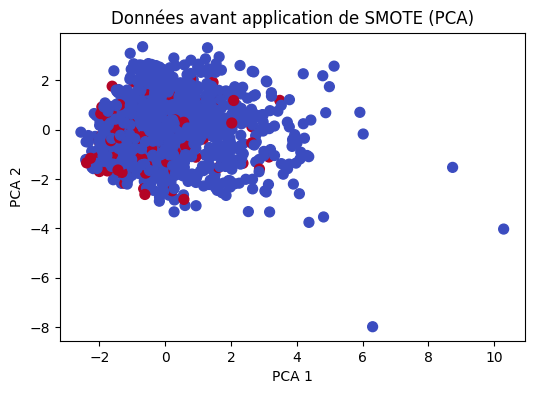

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualiser les données avant rééchantillonnage
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', s=50)
plt.title("Données avant application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Echantillonage des classes

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

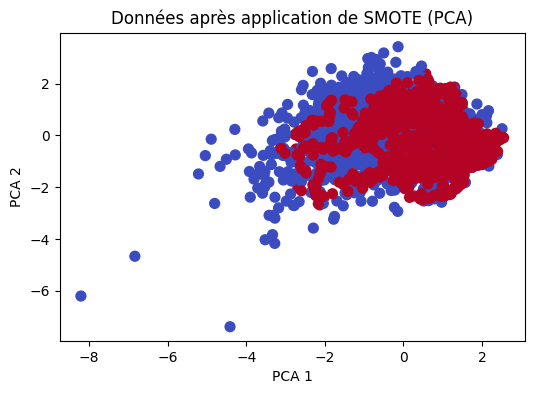

In [20]:
X_train_resampled_pca = pca.fit_transform(X_train_resampled)

# Visualiser les données rééchantillonnées après réduction de dimension
plt.figure(figsize=(6, 4))
plt.scatter(X_train_resampled_pca[:, 0], X_train_resampled_pca[:, 1], c=y_train_resampled, cmap='coolwarm', s=50)
plt.title("Données après application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Modèle

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [22]:
model = LogisticRegression()

# Définir la grille de paramètres
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],            # Coefficient de régularisation
    'penalty': ['l1', 'l2'],                        # Types de pénalité
    'solver': ['liblinear', 'saga'],                # Algorithmes d'optimisation (retirez lbfgs et sag)
    'max_iter': [100, 200, 300],                    # Nombre maximum d'itérations
    'class_weight': ['balanced'],              # Poids des classes
}

# Créez le GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Entraînez le modèle
grid_search.fit(X_train_resampled, y_train_resampled)

# Affichez les meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)
accuracy_test = grid_search.best_estimator_.score(X_test, y_test)
accuracy_test

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres :  {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


c:\Users\tosca\OneDrive\Desktop\Epitech M1\Piscine data\Rush 4\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\tosca\OneDrive\Desktop\Epitech M1\Piscine data\Rush 4\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.8753623188405797

In [23]:
model = LogisticRegression()                            # équilibrage des classes inutile.
model.fit(X_train_resampled, y_train_resampled)                         

LogisticRegression()

In [24]:
y_pred = model.predict(X_test_scaled) 

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6579710144927536

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       306
           1       0.18      0.59      0.28        39

    accuracy                           0.66       345
   macro avg       0.56      0.63      0.53       345
weighted avg       0.84      0.66      0.72       345



<function matplotlib.pyplot.show(close=None, block=None)>

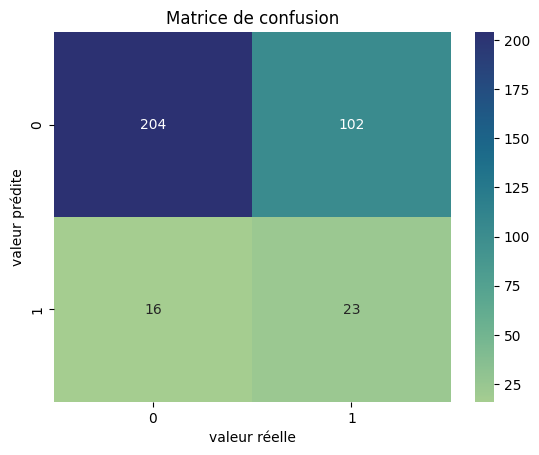

In [26]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix,annot=True, fmt='d', cmap='crest')
plt.title("Matrice de confusion")
plt.xlabel("valeur réelle")
plt.ylabel("valeur prédite")
plt.show

In [27]:
#Classification 

column_names = ['month', 'credit_amount', 'credit_term (month)', 'age', 'sex', 'education', 'product_type', 'having_children_flg', 'region', 'income', 'family_status', 'phone_operator', 'is_client']

new_data = pd.DataFrame([[
    11,                                 # month     Observation : A énormément de poid la décision du model
    50000,                              # credit_amount 
    12,                                 # credit_term 
    24,                                 # age 
    'female',                           # sex 
    'Incomplete secondary education',   # education
    'cellphone',                        # product_type
    3,                                  # having_children_flg
    1,                                  # region
    9000,                               # income
    'Unmarried',                        # family_status
    1,                                  # phone_operator
    1                                   # is_client
]], columns=column_names)

new_data['sex'] = le_sex.transform(new_data['sex'])
new_data['education'] = ordinal_encoder.transform(new_data[['education']])
new_data[['product_type', 'family_status']] = target_encoder.transform(new_data[['product_type', 'family_status']])


new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
prediction_proba = model.predict_proba(new_data_scaled)[:,1]
print(f"Prédiction pour la nouvelle donnée : {prediction} avec une proba de {prediction_proba}")

Prédiction pour la nouvelle donnée : [1] avec une proba de [0.70514732]


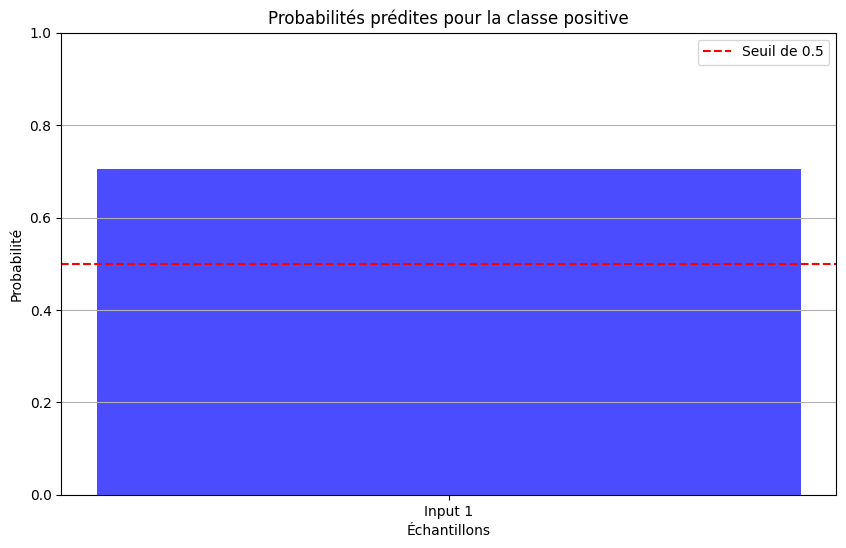

In [28]:
# Tracer les probabilités
plt.figure(figsize=(10, 6))
plt.bar(range(len(prediction_proba)), prediction_proba, color='blue', alpha=0.7)
plt.xticks(range(len(prediction_proba)), [f'Input {i+1}' for i in range(len(prediction_proba))])
plt.title('Probabilités prédites pour la classe positive')
plt.xlabel('Échantillons')
plt.ylabel('Probabilité')
plt.ylim(0, 1)
plt.grid(axis='y')

# Ajouter une ligne de seuil
threshold = 0.5  # Seuil par défaut pour la classification
plt.axhline(y=threshold, color='red', linestyle='--', label='Seuil de 0.5')
plt.legend()

plt.show()

In [29]:
#Classification 

column_names = ['month', 'credit_amount', 'credit_term (month)', 'age', 'sex', 'education', 'product_type', 'having_children_flg', 'region', 'income', 'family_status', 'phone_operator', 'is_client']

new_data = pd.DataFrame([[
    11,                                 # month     Observation : A énormément de poid la décision du model
    50000,                              # credit_amount 
    12,                                 # credit_term 
    24,                                 # age 
    'female',                           # sex 
    'Incomplete secondary education',   # education
    'cellphone',                        # product_type
    3,                                  # having_children_flg
    1,                                  # region
    9000,                               # income
    'Unmarried',                        # family_status
    1,                                  # phone_operator
    1                                   # is_client
]], columns=column_names)

new_data['sex'] = le_sex.transform(new_data['sex'])
new_data['education'] = ordinal_encoder.transform(new_data[['education']])
new_data[['product_type', 'family_status']] = target_encoder.transform(new_data[['product_type', 'family_status']])


new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
prediction_proba = model.predict_proba(new_data_scaled)[:,1]
print(f"Prédiction pour la nouvelle donnée : {prediction} avec une proba de {prediction_proba}")

Prédiction pour la nouvelle donnée : [1] avec une proba de [0.70514732]


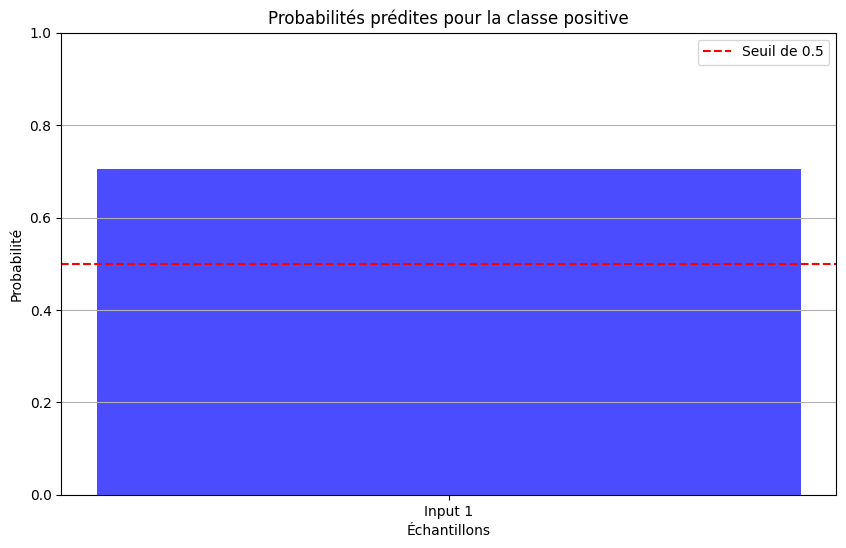

In [30]:
# Tracer les probabilités
plt.figure(figsize=(10, 6))
plt.bar(range(len(prediction_proba)), prediction_proba, color='blue', alpha=0.7)
plt.xticks(range(len(prediction_proba)), [f'Input {i+1}' for i in range(len(prediction_proba))])
plt.title('Probabilités prédites pour la classe positive')
plt.xlabel('Échantillons')
plt.ylabel('Probabilité')
plt.ylim(0, 1)
plt.grid(axis='y')

# Ajouter une ligne de seuil
threshold = 0.5  # Seuil par défaut pour la classification
plt.axhline(y=threshold, color='red', linestyle='--', label='Seuil de 0.5')
plt.legend()

plt.show()

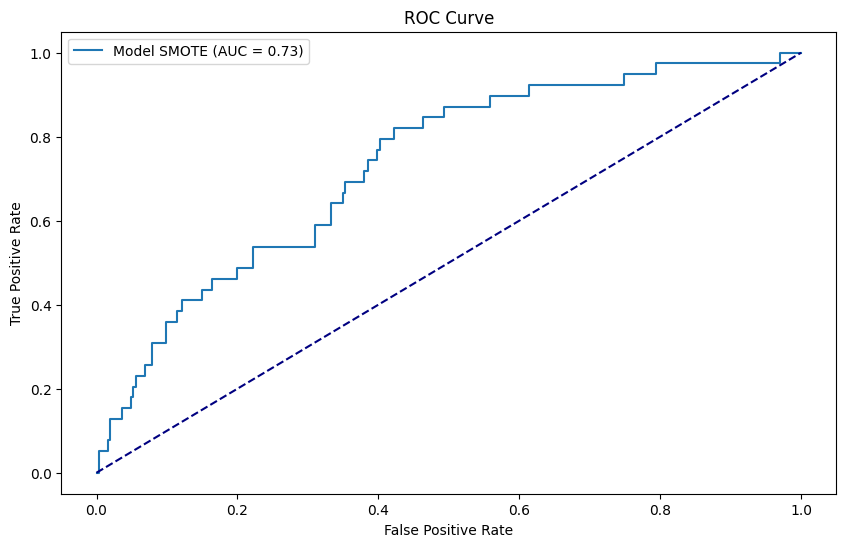

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prédiction des probabilités
y_pred_proba_smote = model.predict_proba(X_test_scaled)[:, 1]  # Pour le modèle SMOTE

# Courbe ROC
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)

# AUC
auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(fpr_smote, tpr_smote, label=f'Model SMOTE (AUC = {auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
